In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.fft import fft
import tensorflow as tf

# 1. Preprocessing Pipeline

In [2]:
def cot(tach, Fs_tach, ppr, trigger, vibration, Fs_vibration, orders):

    # Step 1: Create the tachometer time array
    dt_tach = 1 / Fs_tach            # Time step for tachometer
    N_tach = len(tach)                # Number of samples in tachometer signal
    t_tach = np.linspace(0, N_tach * dt_tach, N_tach)  # Tachometer time array
    
    # Step 2: Detect pulses based on the trigger level
    pulse_indices = np.where(tach >= trigger)[0]  # Indices of pulses in tachometer signal
    
    # Filter pulses to get indices of each PPRth pulse (for one revolution)
    ppr_indices = pulse_indices[::ppr]           # One index per revolution
    
    # Step 3: Define order sampling points per revolution
    N_orders = orders  # Number of samples per revolution (order resolution)
    
    # Initialize order domain arrays
    t_cot = []
    sig_cot = []
    
    # Step 4: Loop through each revolution to resample the vibration signal
    for i in range(len(ppr_indices) - 1):
        # Time interval for one revolution
        t_start = t_tach[ppr_indices[i]]
        t_end = t_tach[ppr_indices[i + 1]]
        
        # Generate order domain sampling points within the revolution
        t_order = np.linspace(t_start, t_end, N_orders)
        
        # Resample the vibration signal at these order points using interpolation
        sig_order = np.interp(t_order, np.arange(len(vibration)) / Fs_vibration, vibration)
        
        # Append to order domain arrays
        t_cot.extend(t_order)
        sig_cot.extend(sig_order)
    
    # Convert lists to numpy arrays for easier handling
    t_cot = np.array(t_cot)
    sig_cot = np.array(sig_cot)
    
    return t_cot, sig_cot

def preprocess_vibration_data(file_paths, time_start, time_end, original_sampling_rate, target_sampling_rate, 
                              segment_length, target_num_segments, snr_db_lower, snr_db_upper, 
                              num_classes=3, random_state=42, overlap=0.0):
    """
    Preprocess vibration data for both time and frequency domain, including COT and its frequency transform.
    """

    def process_signal(data):
        downsample_factor = original_sampling_rate / target_sampling_rate
        nyquist_freq = target_sampling_rate / 2
        cutoff_freq = nyquist_freq * 0.95
        b, a = butter(N=10, Wn=cutoff_freq / (original_sampling_rate / 2), btype='low')
        filtered_signal = filtfilt(b, a, data)
        target_num_points = int(len(filtered_signal) / downsample_factor)
        return resample(filtered_signal, target_num_points)

    def cut_signals(signal_data, start_idx, end_idx):
        return signal_data[:, start_idx:end_idx]

    def segment_vibration_data(signal_data, segment_length, overlap=0.5):
        step_size = int(segment_length * (1 - overlap))
        segmented_data = []

        for data in signal_data:
            num_segments = (len(data) - segment_length) // step_size + 1
            segments = [data[i * step_size:i * step_size + segment_length] for i in range(num_segments)]
            segmented_data.append(np.array(segments))

        return segmented_data

    def augment_segments_with_snr(segments, snr_db_lower, snr_db_upper, target_num_segments):
        augmented_segments = []
        num_augmentations_per_segment = max(1, target_num_segments // len(segments))

        for segment in segments:
            for _ in range(num_augmentations_per_segment):
                snr_db = np.random.uniform(snr_db_lower, snr_db_upper)
                snr_linear = 10 ** (snr_db / 10)
                signal_power = np.mean(segment ** 2)
                noise_power = signal_power / snr_linear
                noise = np.sqrt(noise_power) * np.random.randn(*segment.shape)
                augmented_segments.append(segment + noise)

        return np.array(augmented_segments[:target_num_segments])

    def compute_cot(Fs, vibration_signal, angular_velocity, pulses_per_revolution=60, orders=4096):
        """
        Compute Continuous Order Tracking (COT).
        """
        num_channels = vibration_signal.shape[0]
        target_length = vibration_signal.shape[1]
        sig_cots = []

        for ch in range(num_channels):
            dt = 1 / Fs
            cumulative_angle = np.cumsum(angular_velocity[ch] * dt)
            pulse_interval = 2 * np.pi / pulses_per_revolution

            tachometer_signal = np.zeros_like(angular_velocity[ch])
            pulse_count = 0
            for i in range(1, len(cumulative_angle)):
                if cumulative_angle[i] >= (pulse_count + 1) * pulse_interval:
                    tachometer_signal[i] = 1
                    pulse_count += 1

            _, sig_cot = cot(
                tach=tachometer_signal,
                Fs_tach=Fs,
                ppr=pulses_per_revolution,
                trigger=1,
                vibration=vibration_signal[ch],
                Fs_vibration=Fs,
                orders=orders
            )

            sig_cot = np.pad(sig_cot, (0, max(0, target_length - len(sig_cot))), 'constant')[:target_length]
            sig_cots.append(sig_cot)

        return np.array(sig_cots)

    def transform_to_frequency_domain(segments):
        freq_segments = [np.abs(fft(segment)) for segment in segments]
        return np.array(freq_segments)

    # Load vibration and rotation data
    vibration_data = [pd.read_csv(fp)['Pinion_Y_Acceleration'].values for fp in file_paths]
    rotation_data = [pd.read_csv(fp)['Pinion_Angular_Velocity'].values for fp in file_paths]

    # Process each dataset independently
    segmented_vibration, segmented_cot = [], []
    for vib_data, rot_data in zip(vibration_data, rotation_data):
        resampled_vib = process_signal(vib_data)
        resampled_rot = process_signal(rot_data)
        
        cut_vib = cut_signals(np.array([resampled_vib]), int(time_start * target_sampling_rate), int(time_end * target_sampling_rate))
        cut_rot = cut_signals(np.array([resampled_rot]), int(time_start * target_sampling_rate), int(time_end * target_sampling_rate))

        cut_cot = compute_cot(target_sampling_rate, cut_vib, cut_rot, pulses_per_revolution=60, orders=4096)

        segmented_vibration.append(segment_vibration_data(cut_vib, segment_length, overlap)[0])
        segmented_cot.append(segment_vibration_data(cut_cot, segment_length, overlap)[0])

    # Augment and relabel
    all_vibration_segments, all_cot_segments = [], []
    all_freq_segments, all_cotf_segments = [], []
    all_labels = []
    for idx, (vib_seg, cot_seg) in enumerate(zip(segmented_vibration, segmented_cot)):
        augmented_vib = augment_segments_with_snr(vib_seg, snr_db_lower, snr_db_upper, target_num_segments)
        augmented_cot = augment_segments_with_snr(cot_seg, snr_db_lower, snr_db_upper, target_num_segments)

        freq_vib = transform_to_frequency_domain(augmented_vib)
        freq_cot = transform_to_frequency_domain(augmented_cot)

        all_vibration_segments.append(augmented_vib)
        all_freq_segments.append(freq_vib)
        all_cot_segments.append(augmented_cot)
        all_cotf_segments.append(freq_cot)

        all_labels.extend([idx] * len(augmented_vib))

    # Merge constant and varying loads
    merged_vibration, merged_freq = [], []
    merged_cot, merged_cotf, merged_labels = [], [], []
    for health_state, (constant_idx, varying_idx) in enumerate([(0, 3), (1, 4), (2, 5)]):
        merged_vibration.append(np.concatenate([all_vibration_segments[constant_idx], all_vibration_segments[varying_idx]]))
        merged_freq.append(np.concatenate([all_freq_segments[constant_idx], all_freq_segments[varying_idx]]))
        merged_cot.append(np.concatenate([all_cot_segments[constant_idx], all_cot_segments[varying_idx]]))
        merged_cotf.append(np.concatenate([all_cotf_segments[constant_idx], all_cotf_segments[varying_idx]]))
        merged_labels.extend([health_state] * (len(all_vibration_segments[constant_idx]) + len(all_vibration_segments[varying_idx])))

    return (
        np.concatenate(merged_vibration), 
        np.concatenate(merged_freq), 
        np.array(merged_labels),
        np.concatenate(merged_cot),
        np.concatenate(merged_cotf),
        np.array(merged_labels)
    )

In [3]:
def train_and_evaluate_1d_cnn(X_train, y_train, X_val, y_val, X_test, y_test, 
                              num_classes=3, epochs=100, batch_size=50):
    """
    Train and evaluate a 1D-CNN model.
    
    Parameters:
    - X_train, X_val, X_test: Training, validation, and test data.
    - y_train, y_val, y_test: Corresponding labels.
    - num_classes (int): Number of output classes.
    - epochs (int): Training epochs.
    - batch_size (int): Batch size.
    
    Returns:
    None
    """

    # Model definition
    model = Sequential([
        Conv1D(10, kernel_size=64, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(30, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.02, momentum=0.5, decay=0.04), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    #print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Plot Loss
    #plt.plot(history.history['loss'], label='Train Loss')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    #plt.legend()
    #plt.title('Loss Curve')
    #plt.show()
    
    # Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    #ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    #plt.title('Confusion Matrix')
    #plt.show()
    
    return history, test_loss, test_accuracy, cm

# Data normalization
def normalize_and_standardize(X_train, X_val, X_test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_val_scaled = scaler.transform(X_val.reshape(X_val.shape[0], -1))
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))
    
    standardizer = StandardScaler()
    X_train_standardized = standardizer.fit_transform(X_train_scaled).reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val_standardized = standardizer.transform(X_val_scaled).reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test_standardized = standardizer.transform(X_test_scaled).reshape(X_test.shape[0], X_test.shape[1], 1)
    
    return X_train_standardized, X_val_standardized, X_test_standardized

In [4]:
file_paths = ["1_C_H.csv", "2_C_CT.csv", "3_C_WT.csv", "4_V_H.csv", "5_V_CT.csv", "6_V_WT.csv"]

# Constants
NUM_RUNS = 10  # Number of training runs for each segment length
SEGMENT_LENGTHS = [1024, 2048, 3072, 4096, 5120, 6144]

# Dictionary to store results for each dataset, segment length, and run
results = {
    "Time Domain": {},
    "Frequency Domain": {},
    "COT": {},
    "COT Frequency": {}
}

aggregated_metrics = {
    dataset_name: {length: {'test_accuracies': [], 'conf_matrices': [], 'histories': []} for length in SEGMENT_LENGTHS}
    for dataset_name in results.keys()
}

for segment_length in SEGMENT_LENGTHS:
    print(f"\nProcessing for segment length: {segment_length}")

    # Preprocess data for the given segment length
    time_segments, freq_segments, all_labels, cot_segments, cotf_segments, cot_labels = preprocess_vibration_data(
        file_paths,
        time_start=1.0, time_end=4.1,
        original_sampling_rate=200000, target_sampling_rate=20000,
        segment_length=segment_length, target_num_segments=30,
        snr_db_lower=0, snr_db_upper=20
    )

    # Relabeling
    for i in range(len(all_labels)):
        if all_labels[i] == 3:
            all_labels[i] = 0
        if all_labels[i] == 4:
            all_labels[i] = 1
        if all_labels[i] == 5:
            all_labels[i] = 2
    
    cot_labels = all_labels

    datasets = {
        "Time Domain": (time_segments, all_labels),
        "Frequency Domain": (freq_segments, all_labels),
        "COT": (cot_segments, cot_labels),
        "COT Frequency": (cotf_segments, cot_labels)
    }

    for dataset_name, (segments, labels) in datasets.items():
        print(f"\nTraining {dataset_name} model for segment length {segment_length}...")

        for run in range(NUM_RUNS):
            print(f"Run {run + 1}/{NUM_RUNS}")

            # Split the data
            X_train, X_temp, y_train, y_temp = train_test_split(
                segments, labels, test_size=0.3, stratify=labels, random_state=42 + run
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42 + run
            )

            # Normalize and standardize datasets
            X_train, X_val, X_test = normalize_and_standardize(X_train, X_val, X_test)

            # One-hot encode labels
            y_train = to_categorical(y_train, num_classes=3)
            y_val = to_categorical(y_val, num_classes=3)
            y_test = to_categorical(y_test, num_classes=3)

            # Convert datasets to TensorFlow tensors
            X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
            X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
            X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

            # Train the model
            history, test_loss, test_accuracy, cm = train_and_evaluate_1d_cnn(
                X_train, y_train, X_val, y_val, X_test, y_test
            )

            # Store results for this run
            aggregated_metrics[dataset_name][segment_length]['test_accuracies'].append(test_accuracy)
            aggregated_metrics[dataset_name][segment_length]['conf_matrices'].append(cm)
            aggregated_metrics[dataset_name][segment_length]['histories'].append(history.history)


Processing for segment length: 1024

Training Time Domain model for segment length 1024...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1481 - loss: 4.1252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1111 - loss: 4.1201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 5.4346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1111 - loss: 6.1489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1111 - loss: 4.8384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1481 - loss: 4.9774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0741 - loss: 4.9811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1111 - loss: 4.6780
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0741 - loss: 4.8632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2222 - loss: 4.0060
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Training Frequency Domain model for segment length 1024...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8889 - loss: 0.2598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8148 - loss: 0.5638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7407 - loss: 0.6677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8889 - loss: 0.1929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7778 - loss: 0.4141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8889 - loss: 0.3960
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8889 - loss: 0.5052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8519 - loss: 0.3738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8519 - loss: 0.3349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8148 - loss: 0.8292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training COT model for segment length 1024...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3704 - loss: 2.4141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3704 - loss: 1.8991
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.5721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.7595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3333 - loss: 2.0244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4074 - loss: 1.9805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4074 - loss: 1.4369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4074 - loss: 2.1892
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3704 - loss: 2.0335
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3333 - loss: 2.1557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Training COT Frequency model for segment length 1024...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.6438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6296 - loss: 1.1093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4444 - loss: 1.6456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7407 - loss: 0.5065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5926 - loss: 1.2101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.2960
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5556 - loss: 1.6477
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5556 - loss: 1.2564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3333 - loss: 2.3752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6296 - loss: 1.1912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Processing for segment length: 2048

Training Time Domain model for segment length 2048...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1481 - loss: 3.8965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0370 - loss: 4.4204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0370 - loss: 4.8632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0370 - loss: 4.4857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1852 - loss: 3.5545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1481 - loss: 3.5281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1111 - loss: 4.8734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1481 - loss: 3.7889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1111 - loss: 4.7094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1111 - loss: 4.6819
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Training Frequency Domain model for segment length 2048...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9630 - loss: 0.1300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9630 - loss: 0.0698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9259 - loss: 0.1591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8889 - loss: 0.3087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9259 - loss: 0.0790
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8519 - loss: 0.2031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9630 - loss: 0.3066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8148 - loss: 0.3616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9630 - loss: 0.2912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9630 - loss: 0.1224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Training COT model for segment length 2048...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 2.4569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6296 - loss: 1.0569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5556 - loss: 1.5425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 1.8551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 1.4805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4815 - loss: 2.2781
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 1.7866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 1.7779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2963 - loss: 2.3445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4815 - loss: 2.2378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Training COT Frequency model for segment length 2048...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4815 - loss: 1.4585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5556 - loss: 1.1764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 1.4602
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6296 - loss: 1.8330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 1.5572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.6361
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.3593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 1.5511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4815 - loss: 1.3690
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 2.0487
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Processing for segment length: 3072

Training Time Domain model for segment length 3072...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1667 - loss: 4.4102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 5.5563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 5.1503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1667 - loss: 5.7514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 4.9312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 5.1034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0556 - loss: 4.6112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0556 - loss: 4.2830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0556 - loss: 3.9579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0556 - loss: 4.9979
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Training Frequency Domain model for segment length 3072...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7222 - loss: 0.6329
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9444 - loss: 0.3511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0490
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9444 - loss: 0.1601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8333 - loss: 0.3244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8889 - loss: 0.1940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8889 - loss: 0.2199
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training COT model for segment length 3072...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 1.6173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 2.4324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5556 - loss: 1.4887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 2.0032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6111 - loss: 1.0783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3889 - loss: 3.7410
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3333 - loss: 3.4898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4444 - loss: 2.2518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5556 - loss: 2.4053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3333 - loss: 3.9910
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training COT Frequency model for segment length 3072...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9444 - loss: 0.3676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6667 - loss: 1.2392
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7222 - loss: 1.1459
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6111 - loss: 1.1644
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8889 - loss: 0.2998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.4070
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8333 - loss: 0.5865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7778 - loss: 0.7691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6667 - loss: 0.8158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7222 - loss: 0.6484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Processing for segment length: 4096

Training Time Domain model for segment length 4096...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2963 - loss: 3.9113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5926 - loss: 2.2287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4074 - loss: 3.1530
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 2.5820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5556 - loss: 2.2342
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6667 - loss: 1.1096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6667 - loss: 1.1783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6296 - loss: 1.9306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5556 - loss: 2.1950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6296 - loss: 1.1770
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training Frequency Domain model for segment length 4096...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.0795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.2782
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9630 - loss: 0.0696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0268
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.1230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9630 - loss: 0.1532
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training COT model for segment length 4096...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.1761
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.1946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.2419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.4305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.0970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.4363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8519 - loss: 0.3686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7778 - loss: 0.5655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Training COT Frequency model for segment length 4096...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.2749
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.0830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.1276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.0586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.0934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.1653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.1450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.2009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Processing for segment length: 5120

Training Time Domain model for segment length 5120...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5455 - loss: 2.6623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3182 - loss: 3.5755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5909 - loss: 1.3605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5909 - loss: 1.6849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5000 - loss: 2.0989
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5455 - loss: 2.3185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 2.4300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5909 - loss: 1.5301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5455 - loss: 2.3509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6818 - loss: 1.7049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training Frequency Domain model for segment length 5120...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9545 - loss: 0.1027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9091 - loss: 0.1818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8636 - loss: 0.1642
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8636 - loss: 0.2685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9091 - loss: 0.2631
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9091 - loss: 0.1443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training COT model for segment length 5120...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8182 - loss: 0.7592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7727 - loss: 0.6171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7727 - loss: 1.3055
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8636 - loss: 1.1121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7273 - loss: 1.9942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6818 - loss: 2.3803
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6364 - loss: 1.4370
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7273 - loss: 1.0851
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6364 - loss: 1.8948
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7273 - loss: 0.7912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Training COT Frequency model for segment length 5120...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9545 - loss: 0.1463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9545 - loss: 0.1217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7273 - loss: 0.5810
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9091 - loss: 0.2613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8182 - loss: 0.6014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9545 - loss: 0.1514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9091 - loss: 0.2469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8636 - loss: 0.2878
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9545 - loss: 0.1662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Processing for segment length: 6144

Training Time Domain model for segment length 6144...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6667 - loss: 1.0809
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4444 - loss: 1.3455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5556 - loss: 1.3595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7407 - loss: 1.6010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6667 - loss: 2.0540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7037 - loss: 1.4054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7778 - loss: 0.5538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5556 - loss: 0.5902
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6667 - loss: 1.7343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8148 - loss: 0.4073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Training Frequency Domain model for segment length 6144...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9630 - loss: 0.0912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.1486
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9259 - loss: 0.1311
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.1900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.0606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9630 - loss: 0.0985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9259 - loss: 0.2656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.3173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9630 - loss: 0.0895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Training COT model for segment length 6144...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7407 - loss: 0.7274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9259 - loss: 0.1369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8519 - loss: 0.5671
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8889 - loss: 0.4990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7407 - loss: 1.1126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9630 - loss: 0.0994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7778 - loss: 1.1074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7778 - loss: 1.0430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8889 - loss: 0.2983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Training COT Frequency model for segment length 6144...
Run 1/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7778 - loss: 0.4498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 2/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.1734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 3/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9630 - loss: 0.1185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 4/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9259 - loss: 0.1938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 5/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9259 - loss: 0.1095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run 6/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 7/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 8/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Run 9/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8889 - loss: 0.2374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run 10/10


C:\Users\Brad\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Brad\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9630 - loss: 0.1073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step



Time Domain (Segment Length 1024):
  Mean Accuracy: 0.1111
  Std Dev of Accuracy: 0.0549

Time Domain (Segment Length 2048):
  Mean Accuracy: 0.1074
  Std Dev of Accuracy: 0.0509

Time Domain (Segment Length 3072):
  Mean Accuracy: 0.0556
  Std Dev of Accuracy: 0.0609

Time Domain (Segment Length 4096):
  Mean Accuracy: 0.5519
  Std Dev of Accuracy: 0.1129

Time Domain (Segment Length 5120):
  Mean Accuracy: 0.5409
  Std Dev of Accuracy: 0.0897

Time Domain (Segment Length 6144):
  Mean Accuracy: 0.6593
  Std Dev of Accuracy: 0.1071

Frequency Domain (Segment Length 1024):
  Mean Accuracy: 0.8407
  Std Dev of Accuracy: 0.0498

Frequency Domain (Segment Length 2048):
  Mean Accuracy: 0.9222
  Std Dev of Accuracy: 0.0509

Frequency Domain (Segment Length 3072):
  Mean Accuracy: 0.9222
  Std Dev of Accuracy: 0.0868

Frequency Domain (Segment Length 4096):
  Mean Accuracy: 0.9630
  Std Dev of Accuracy: 0.0370

Frequency Domain (Segment Length 5120):
  Mean Accuracy: 0.9409
  Std Dev of Ac

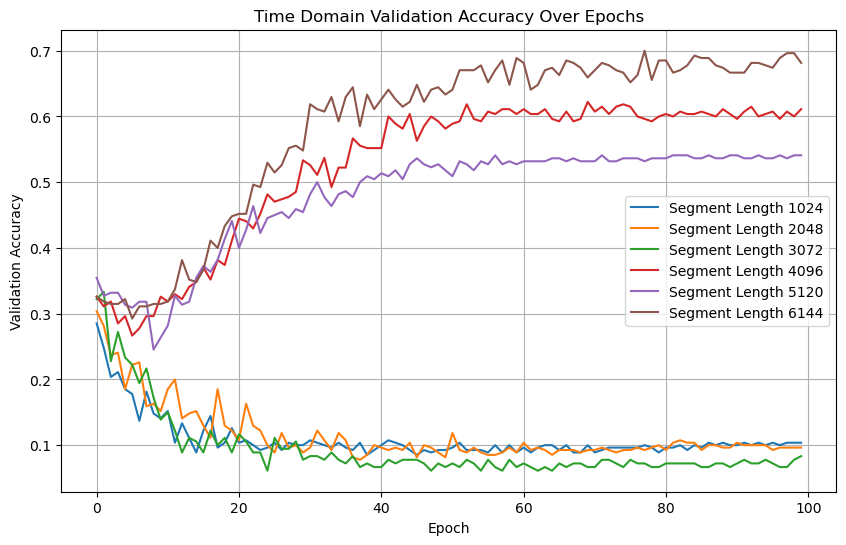

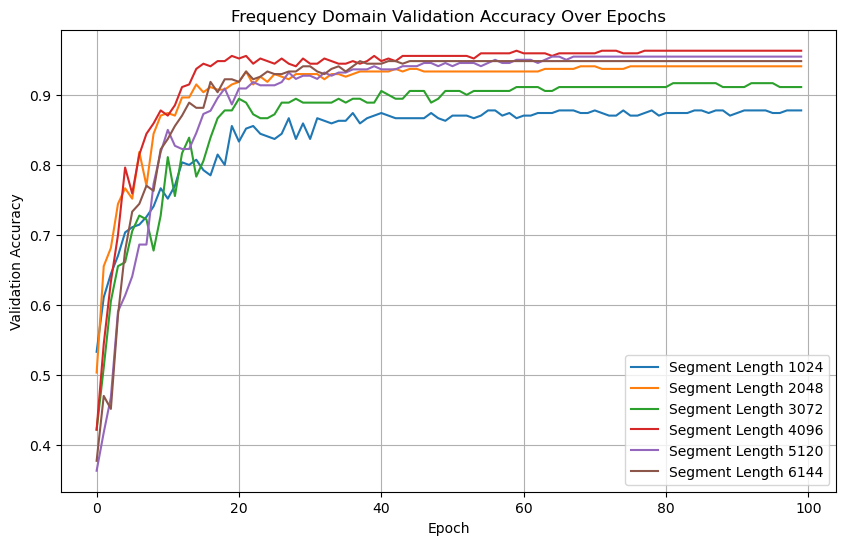

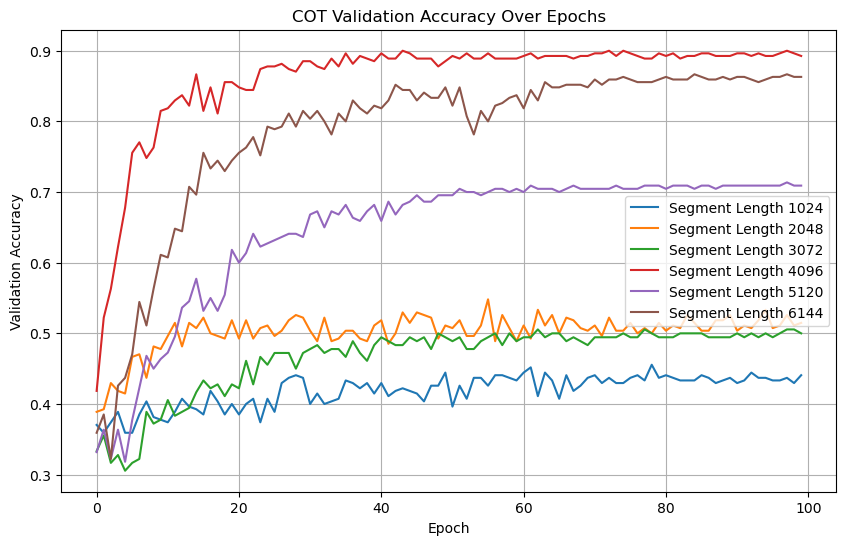

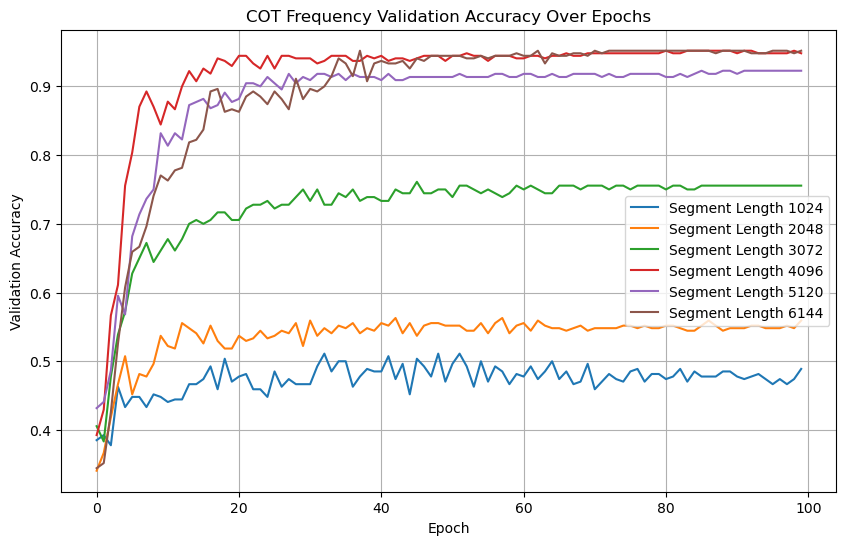

In [5]:
for dataset_name, dataset_results in aggregated_metrics.items():
    for segment_length, metrics in dataset_results.items():
        mean_accuracy = np.mean(metrics['test_accuracies'])
        std_accuracy = np.std(metrics['test_accuracies'])
        
        print(f"\n{dataset_name} (Segment Length {segment_length}):")
        print(f"  Mean Accuracy: {mean_accuracy:.4f}")
        print(f"  Std Dev of Accuracy: {std_accuracy:.4f}")
        
for dataset_name in aggregated_metrics.keys():
    plt.figure(figsize=(10, 6))
    for segment_length in SEGMENT_LENGTHS:
        mean_val_acc = np.mean([h['val_accuracy'] for h in aggregated_metrics[dataset_name][segment_length]['histories']], axis=0)
        plt.plot(mean_val_acc, label=f"Segment Length {segment_length}")
    plt.title(f"{dataset_name} Validation Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

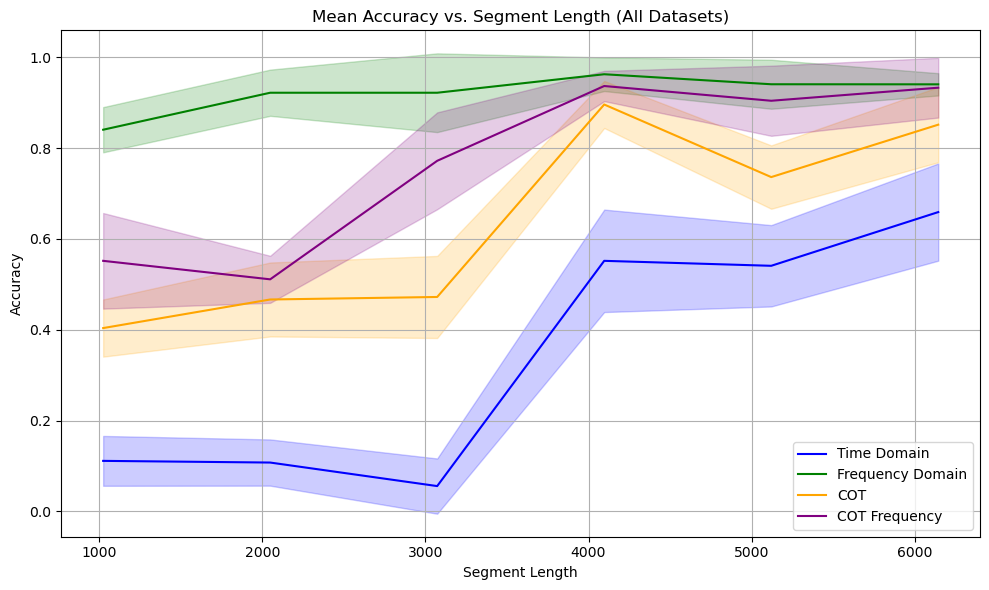

In [6]:
# Define colors for each dataset
colors = {
    "Time Domain": "blue",
    "Frequency Domain": "green",
    "COT": "orange",
    "COT Frequency": "purple"
}

# Create a single plot for all datasets
plt.figure(figsize=(10, 6))
for dataset_name, metrics in aggregated_metrics.items():
    segment_lengths = list(metrics.keys())
    mean_accuracies = [np.mean(metrics[length]['test_accuracies']) for length in segment_lengths]
    std_accuracies = [np.std(metrics[length]['test_accuracies']) for length in segment_lengths]
    
    plt.plot(segment_lengths, mean_accuracies, label=dataset_name, color=colors[dataset_name])
    plt.fill_between(segment_lengths, 
                     np.array(mean_accuracies) - np.array(std_accuracies), 
                     np.array(mean_accuracies) + np.array(std_accuracies), 
                     alpha=0.2, color=colors[dataset_name])

plt.title("Mean Accuracy vs. Segment Length (All Datasets)")
plt.xlabel("Segment Length")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

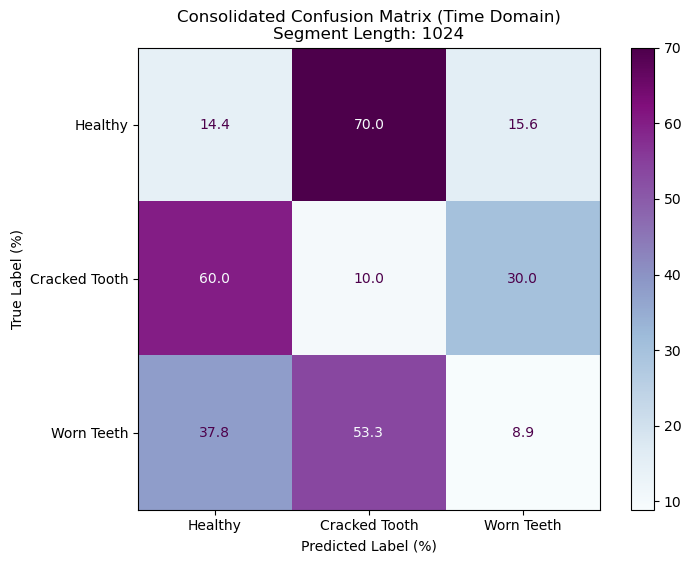

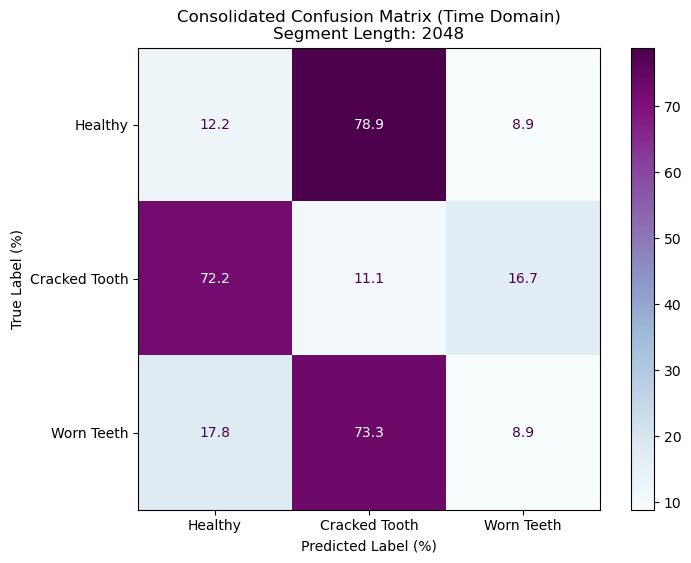

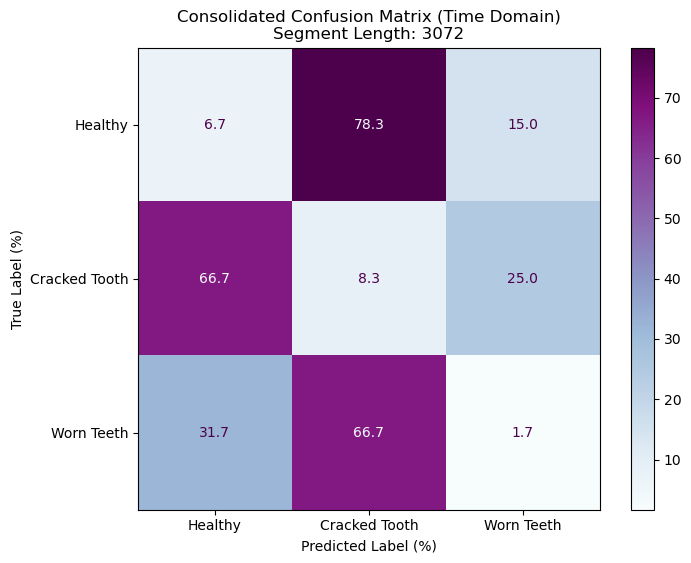

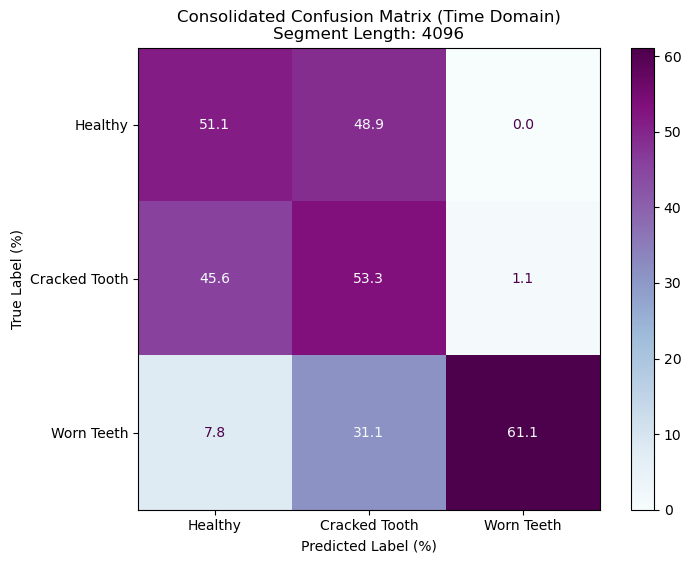

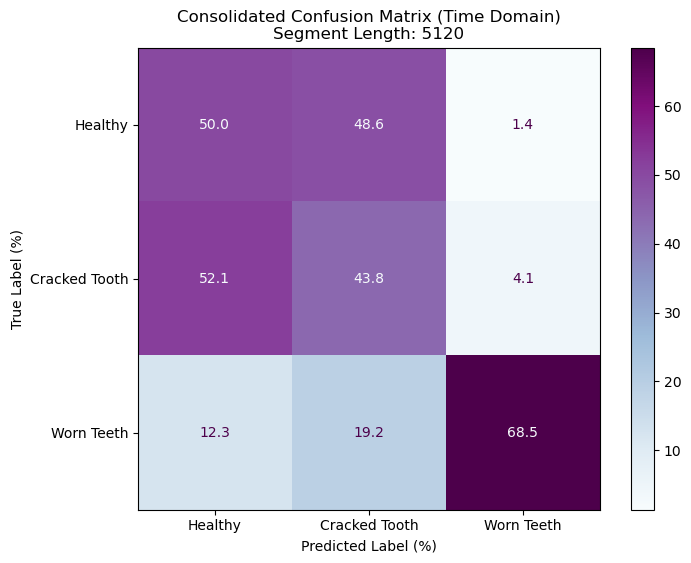

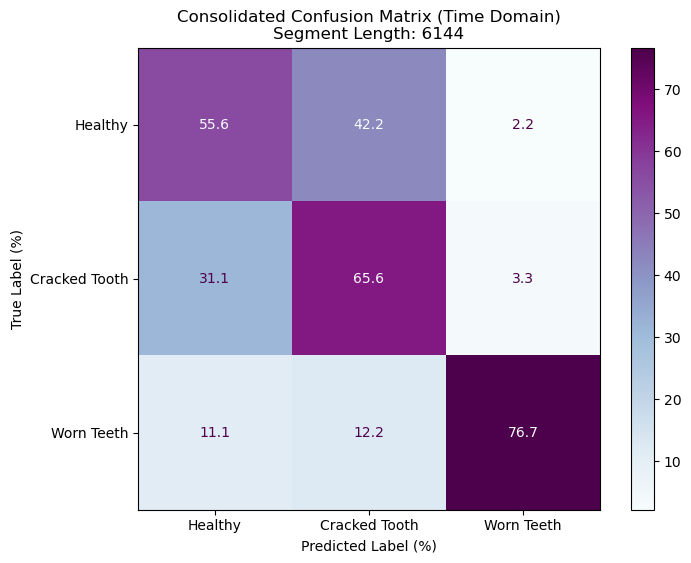

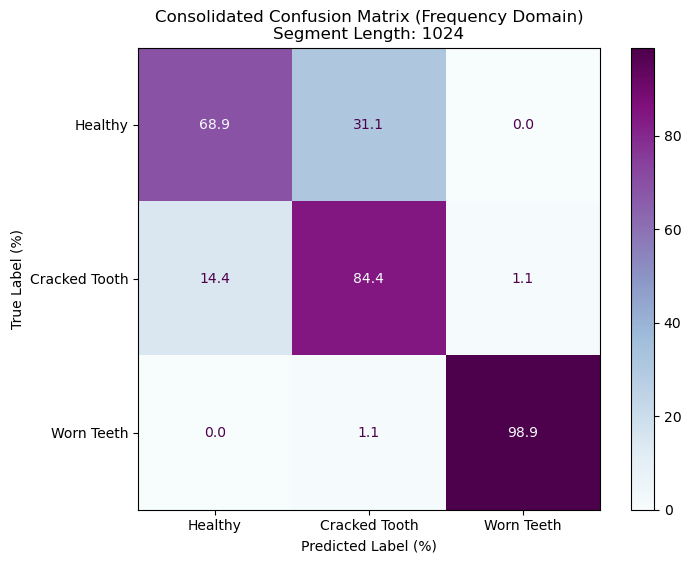

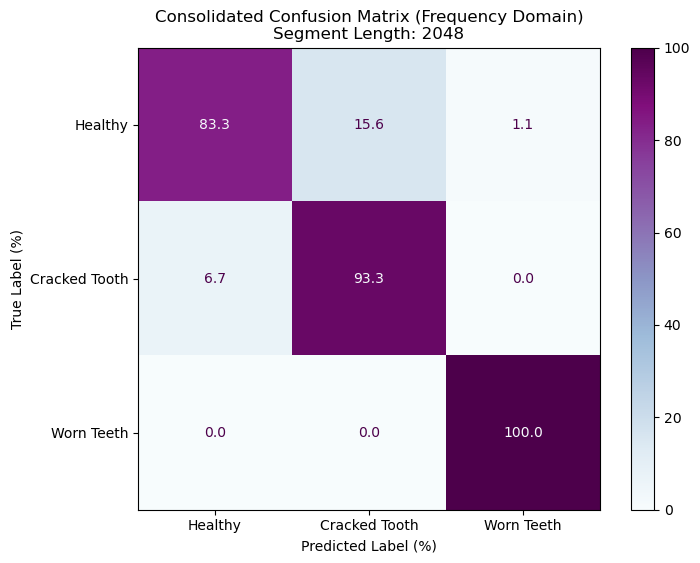

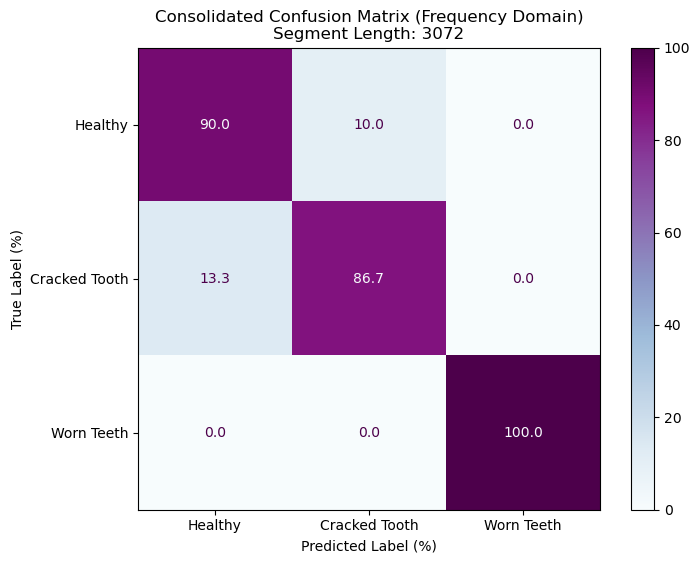

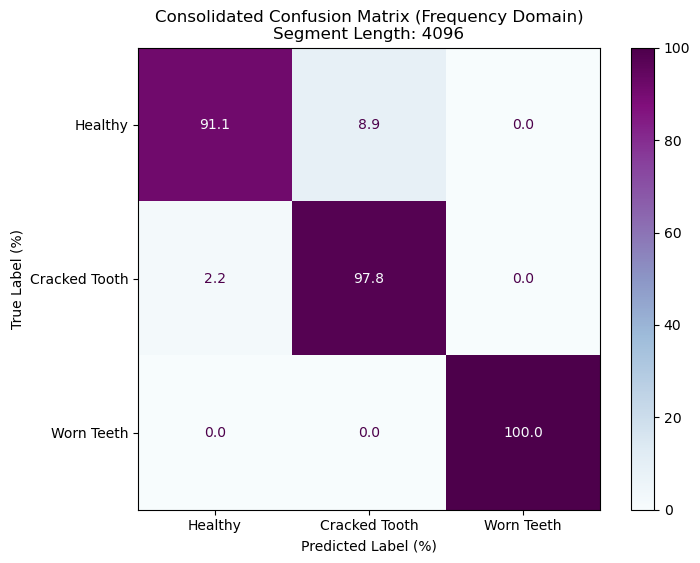

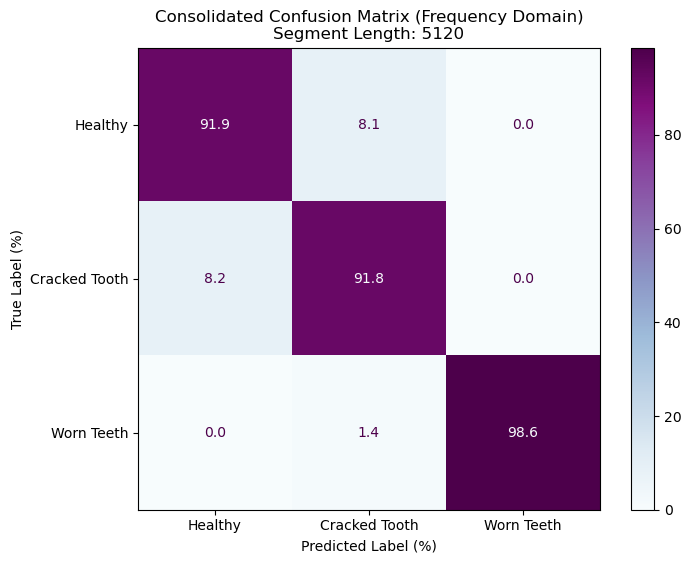

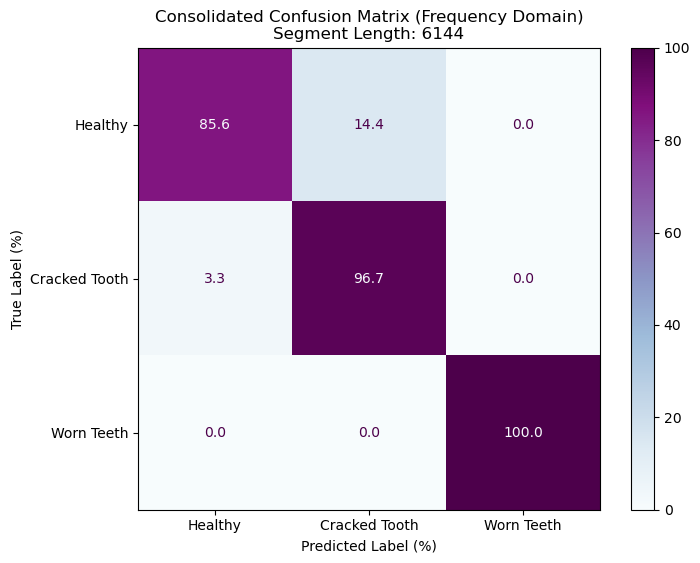

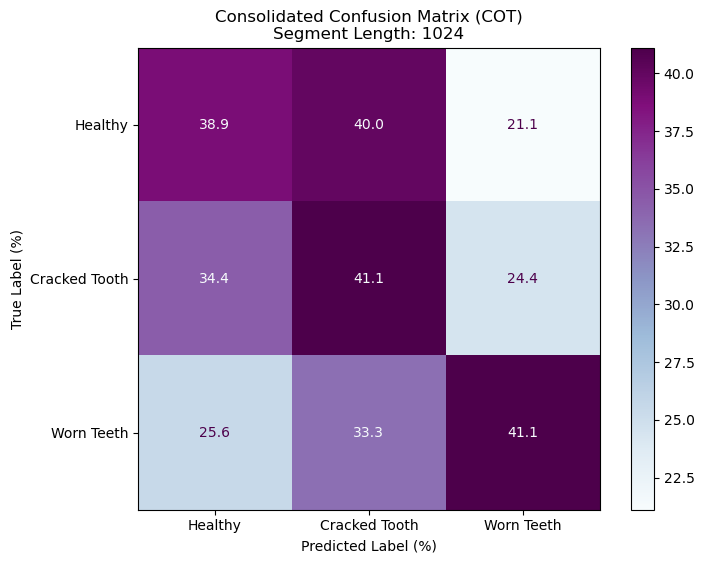

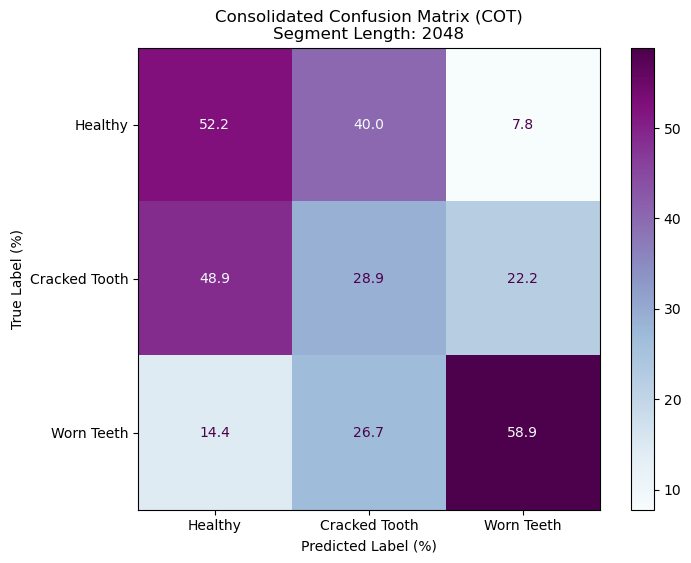

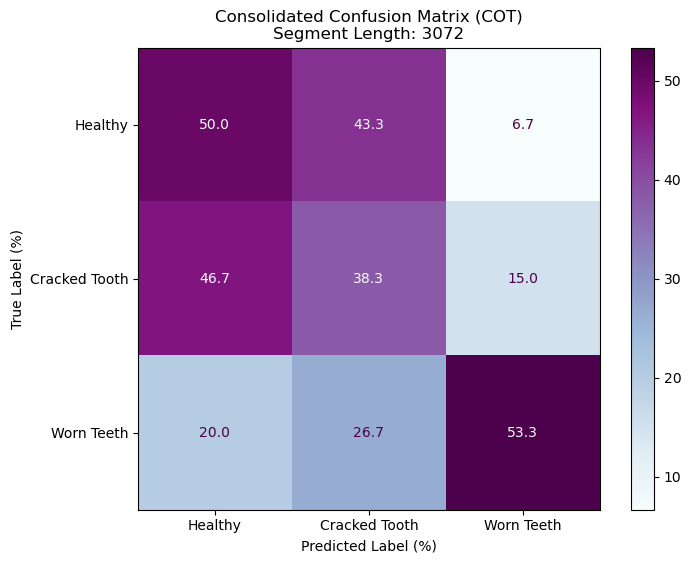

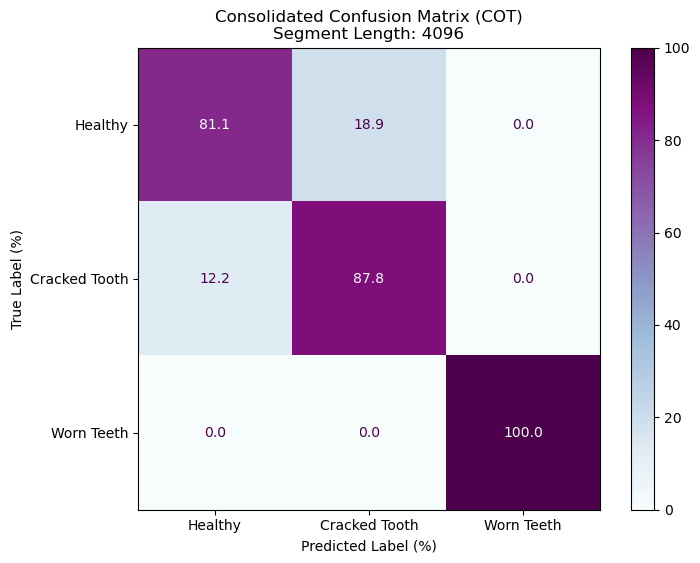

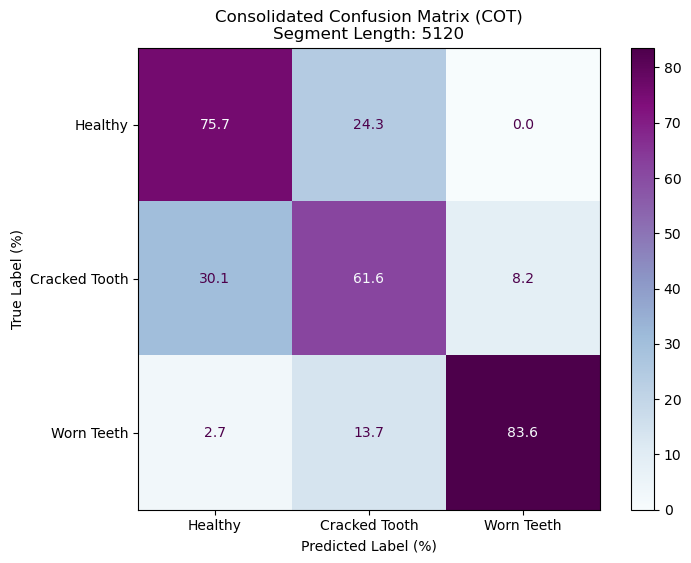

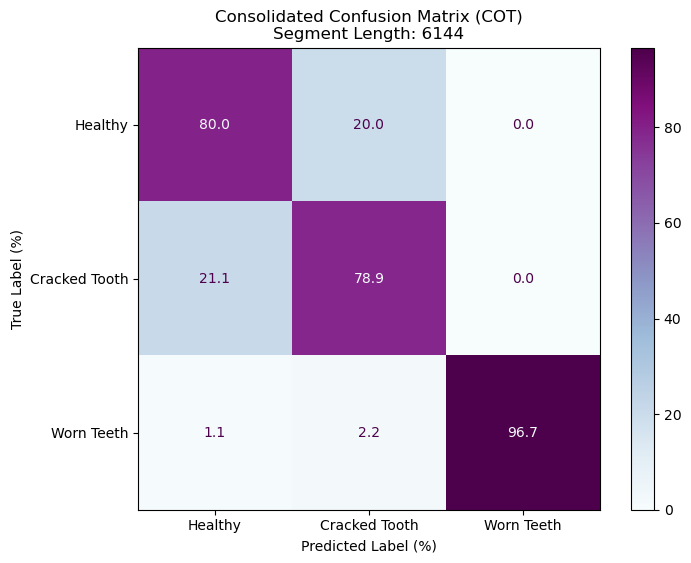

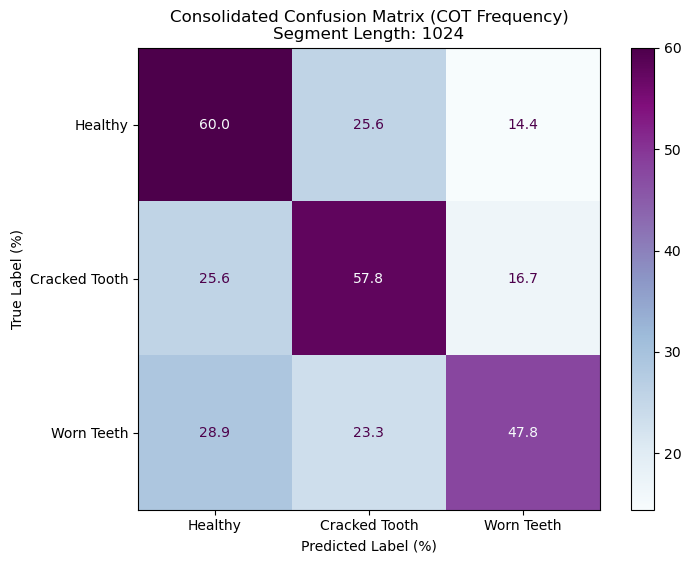

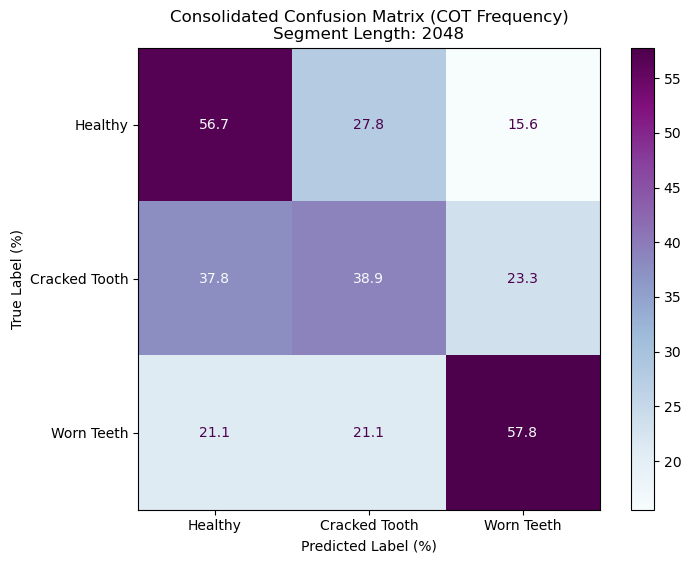

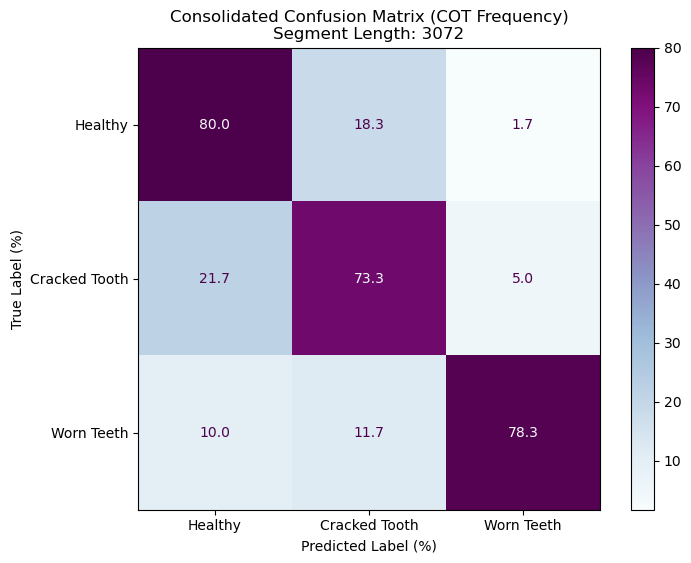

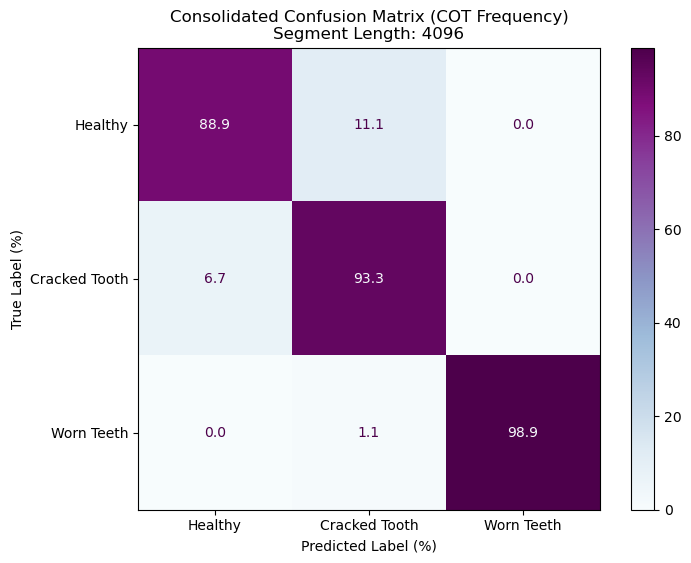

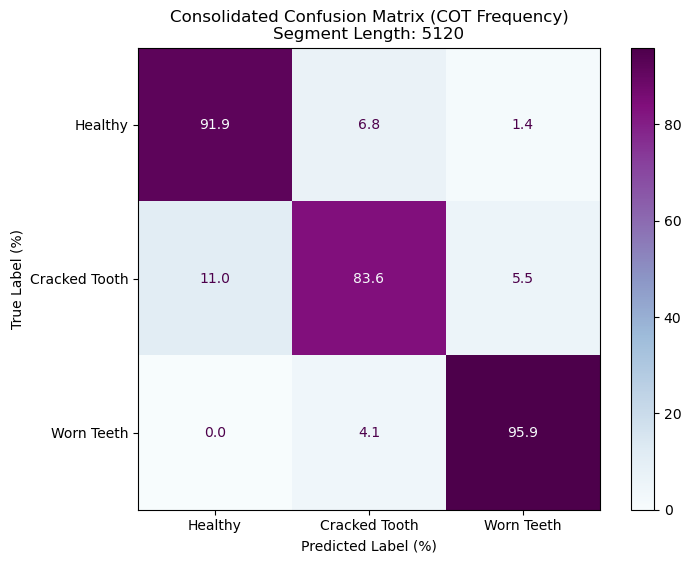

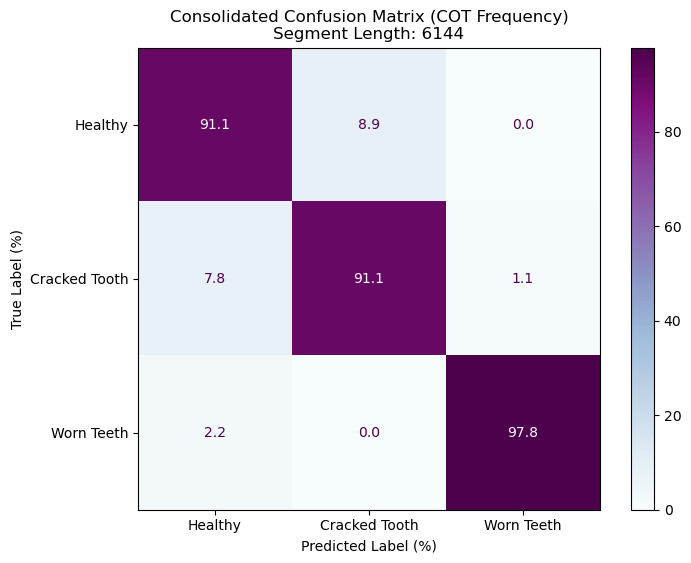

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_consolidated_confusion_matrices(aggregated_metrics, dataset_name):
    """
    Plot consolidated confusion matrices for different segment lengths as percentages.

    Parameters:
    - aggregated_metrics (dict): Dictionary containing test accuracies and confusion matrices for each segment length.
    - dataset_name (str): Name of the dataset (e.g., "Time Domain", "Frequency Domain").
    """
    segment_lengths = sorted(aggregated_metrics[dataset_name].keys())
    
    for segment_length in segment_lengths:
        conf_matrices = np.array(aggregated_metrics[dataset_name][segment_length]['conf_matrices'])
        
        # Average the confusion matrices across runs
        avg_conf_matrix = np.mean(conf_matrices, axis=0)
        
        # Normalize to percentages
        avg_conf_matrix_percentage = avg_conf_matrix / np.sum(avg_conf_matrix, axis=1, keepdims=True) * 100
        
        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix_percentage, display_labels=["Healthy", "Cracked Tooth", "Worn Teeth"])
        disp.plot(cmap="BuPu", ax=ax, values_format=".1f")
        plt.title(f"Consolidated Confusion Matrix ({dataset_name})\nSegment Length: {segment_length}")
        plt.ylabel('True Label (%)')
        plt.xlabel('Predicted Label (%)')
        plt.show()

# Plot consolidated confusion matrices for each dataset
for dataset in aggregated_metrics.keys():
    plot_consolidated_confusion_matrices(aggregated_metrics, dataset)

In [7]:
import pickle

# Save aggregated_metrics to a file
def save_aggregated_metrics(aggregated_metrics, filename="aggregated_metrics.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(aggregated_metrics, f)
    print(f"Aggregated metrics saved to {filename}")

# Call the function with your data
save_aggregated_metrics(aggregated_metrics)

Aggregated metrics saved to aggregated_metrics.pkl


In [ ]:
import pickle

# Load aggregated_metrics from a file
def load_aggregated_metrics(filename="aggregated_metrics.pkl"):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Aggregated metrics loaded from {filename}")
    return data

# Call the function to load data
aggregated_metrics = load_aggregated_metrics()